<a href="https://colab.research.google.com/github/FVargasData/wpgPermits/blob/ExploratoryDataVisualizations/Datathon2025.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import necessary libraries

In [7]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import time
import logging

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Set seaborn pastel palette for visualizations

In [8]:
sns.set_palette("pastel")
sns.set_style("whitegrid")

# Set logging configuration

In [9]:
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Configuration and API parameters

In [10]:
API_URL = "https://data.winnipeg.ca/resource/urbd-qygv.json"
APP_TOKEN = "CvU5WTCBwn36S6Vxebw1QjJVd"
CHUNK_SIZE = 1000  # number of rows per request (Socrata default)
MAX_ROWS = 330000  # maximum rows expected

# Columns to be retained based on our analysis

In [11]:
COLUMNS_TO_KEEP = [
    "issue_date", "permit_group", "permit_type", "sub_type", "work_type",
    "neighbourhood_name", "community", "ward", "application_received_date", "status",
    "x_coordinate_nad83", "y_coordinate_nad83"
]

#FUNCTIONS SECTION

## This function will Fetch all rows from the API using pagination. I will return a DataFrame containing all the data.

In [20]:
def fetch_data(api_url, app_token, chunk_size=1000, max_rows=330000):
    headers = {"X-App-Token": app_token}
    all_data = []
    offset = 0

    logging.info("Starting data collection from API...")
    while offset < max_rows:
        params = {
            "$limit": chunk_size,
            "$offset": offset
        }
        try:
            response = requests.get(api_url, headers=headers, params=params)
            response.raise_for_status()
            data_chunk = response.json()
            if not data_chunk:
                logging.info("No more data returned from API.")
                break
            all_data.extend(data_chunk)
            offset += chunk_size
            logging.info(f"Fetched {len(data_chunk)} rows; total so far: {len(all_data)}")
            # To avoid hitting rate limits
            time.sleep(0.2)
        except Exception as e:
            logging.error("Error during API request: " + str(e))
            break

    logging.info(f"Data collection complete. Total rows fetched: {len(all_data)}")
    return pd.DataFrame(all_data)

## Clean and preprocess the raw DataFrame.

In [31]:
def clean_data(df):

    # Retain only the required columns (if present)
    df = df[[col for col in COLUMNS_TO_KEEP if col in df.columns]].copy()

    # Convert date columns to datetime
    for col in ['issue_date', 'application_received_date']:
        if col in df.columns:
            df[col] = pd.to_datetime(df[col], errors='coerce')
            assert df[col].dtype == '<M8[ns]', f"Column {col} was not converted properly."

    # Convert coordinate columns to numeric
    for col in ['x_coordinate_nad83', 'y_coordinate_nad83']:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')

    # Optional: Clean text columns (strip whitespace)
    text_cols = ['permit_group', 'permit_type', 'sub_type', 'work_type',
                 'neighbourhood_name', 'community', 'ward', 'status']
    for col in text_cols:
        if col in df.columns:
            df[col] = df[col].astype(str).str.strip()

    logging.info("Data cleaning complete.")
    return df

## Process data by adding derived fields.

In [33]:
def process_data(df):

    # Extract year and quarter for grouping
    if "issue_date" in df.columns:
        df["year"] = df["issue_date"].dt.year
        df["quarter"] = df["issue_date"].dt.quarter

        # Create a combined quarter-year field for ease of plotting (e.g., "2022-Q1")
        df["quarter_year"] = df["year"].astype(str) + "-Q" + df["quarter"].astype(str)
        logging.info("Quarter and year columns created.")
    else:
        logging.warning("issue_date column missing, cannot process quarterly fields.")
    return df

## Perform exploratory data analysis (EDA)

In [39]:
def explore_data(df):

    # Permits per quarter per year
    plt.figure(figsize=(15, 6))  # Increased width for better spacing
    quarter_counts = df["quarter_year"].value_counts().sort_index()
    sns.barplot(x=quarter_counts.index, y=quarter_counts.values)
    plt.xticks(rotation=45)
    plt.xlabel("Quarter-Year")
    plt.ylabel("Number of Permits")
    plt.title("Number of Permits per Quarter-Year")
    plt.tight_layout()
    plt.show()

    # Space between charts
    plt.figure(figsize=(0.1, 0.1)) #create a blank plot for spacing.
    plt.show()

    # Distribution of Permit Type
    plt.figure(figsize=(15, 6)) # Increased width for better spacing
    sns.countplot(data=df, x="permit_type", order=df["permit_type"].value_counts().index)
    plt.xticks(rotation=45)
    plt.title("Distribution of Permit Types")
    plt.tight_layout()
    plt.show()

    # Space between charts.
    plt.figure(figsize=(0.1, 0.1)) #create a blank plot for spacing.
    plt.show()

    # Trend of permits per neighbourhood
    plt.figure(figsize=(15, 6)) # Increased width for better spacing
    neighbourhood_counts = df["neighbourhood_name"].value_counts().head(10)
    sns.barplot(x=neighbourhood_counts.index, y=neighbourhood_counts.values)
    plt.xticks(rotation=45)
    plt.xlabel("Neighbourhood Name (Top 10)")
    plt.ylabel("Number of Permits")
    plt.title("Top 10 Neighbourhoods by Permit Count")
    plt.tight_layout()
    plt.show()

    # Space between charts.
    plt.figure(figsize=(0.1, 0.1)) #create a blank plot for spacing.
    plt.show()

    # Map chart: scatter plot of coordinates colored by permits
    if "x_coordinate_nad83" in df.columns and "y_coordinate_nad83" in df.columns:
        plt.figure(figsize=(15, 8)) # Increased width and height for better spacing
        sns.scatterplot(data=df, x="x_coordinate_nad83", y="y_coordinate_nad83", hue="permit_type") #added legend
        plt.xlabel("X Coordinate (NAD83)")
        plt.ylabel("Y Coordinate (NAD83)")
        plt.title("Map Chart: Winnipeg Permit Locations")
        plt.tight_layout()
        plt.show()

    logging.info("Exploratory data analysis complete.")

## Visualize funcitonality

### 1. Data Collection

In [29]:
df_raw = fetch_data(API_URL, APP_TOKEN, chunk_size=CHUNK_SIZE, max_rows=100000)

if df_raw.empty:
  logging.error("No data fetched. Exiting.")

print(df_raw.head())

                issue_date permit_number permit_group             permit_type  \
0  2021-03-24T00:00:00.000  21-130863 ER        Trade  Electrical Residential   
1  2021-06-16T00:00:00.000  21-164934 ER        Trade  Electrical Residential   
2  2021-06-16T00:00:00.000  21-168248 PR        Trade    Plumbing Residential   
3  2021-11-04T00:00:00.000  21-233173 PR        Trade    Plumbing Residential   
4  2021-04-06T00:00:00.000  21-134716 EC        Trade   Electrical Commercial   

                         sub_type               work_type street_number  \
0                       Homeowner            Service Only            15   
1                       Homeowner            Service Only            94   
2                       Homeowner       Plumb Lower Level            34   
3    Licensed Plumbing Contractor           Plumb New SFD          1831   
4  Licensed Electrical Contractor  Temporary Installation           606   

  street_name street_type neighbourhood_number  ...  \
0     D

### 2. Data Cleaning

In [32]:
df_clean = clean_data(df_raw)

print(df_clean.head())

  issue_date permit_group             permit_type  \
0 2021-03-24        Trade  Electrical Residential   
1 2021-06-16        Trade  Electrical Residential   
2 2021-06-16        Trade    Plumbing Residential   
3 2021-11-04        Trade    Plumbing Residential   
4 2021-04-06        Trade   Electrical Commercial   

                         sub_type               work_type neighbourhood_name  \
0                       Homeowner            Service Only          SOUTHDALE   
1                       Homeowner            Service Only       ISLAND LAKES   
2                       Homeowner       Plumb Lower Level          MEADOWOOD   
3    Licensed Plumbing Contractor           Plumb New SFD         BROOKLANDS   
4  Licensed Electrical Contractor  Temporary Installation           McMILLAN   

                    community          ward application_received_date  status  \
0                        Riel  St. Boniface                2021-03-24  Issued   
1                        Riel  St. Bon

### 3. Data Processing

In [34]:
df_processed = process_data(df_clean)

print(df_processed.head())

  issue_date permit_group             permit_type  \
0 2021-03-24        Trade  Electrical Residential   
1 2021-06-16        Trade  Electrical Residential   
2 2021-06-16        Trade    Plumbing Residential   
3 2021-11-04        Trade    Plumbing Residential   
4 2021-04-06        Trade   Electrical Commercial   

                         sub_type               work_type neighbourhood_name  \
0                       Homeowner            Service Only          SOUTHDALE   
1                       Homeowner            Service Only       ISLAND LAKES   
2                       Homeowner       Plumb Lower Level          MEADOWOOD   
3    Licensed Plumbing Contractor           Plumb New SFD         BROOKLANDS   
4  Licensed Electrical Contractor  Temporary Installation           McMILLAN   

                    community          ward application_received_date  status  \
0                        Riel  St. Boniface                2021-03-24  Issued   
1                        Riel  St. Bon

### 4. Exploratory Data Analysis (visualizations)

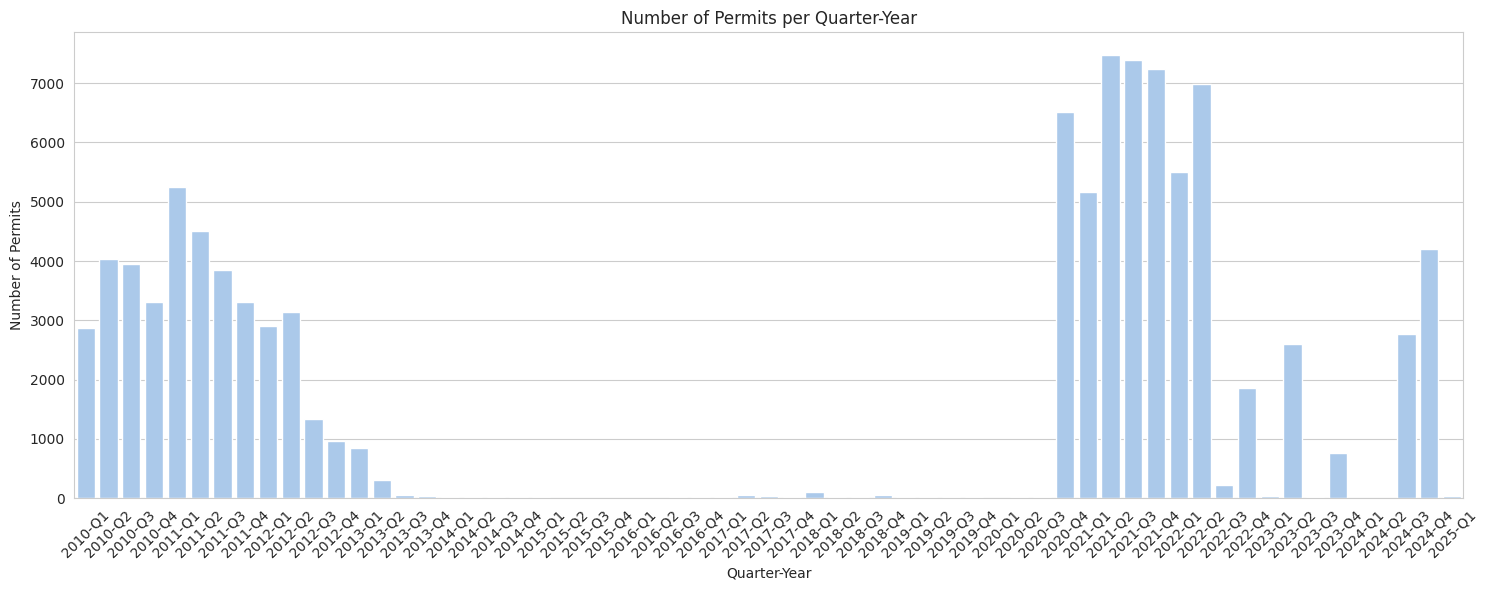

<Figure size 10x10 with 0 Axes>

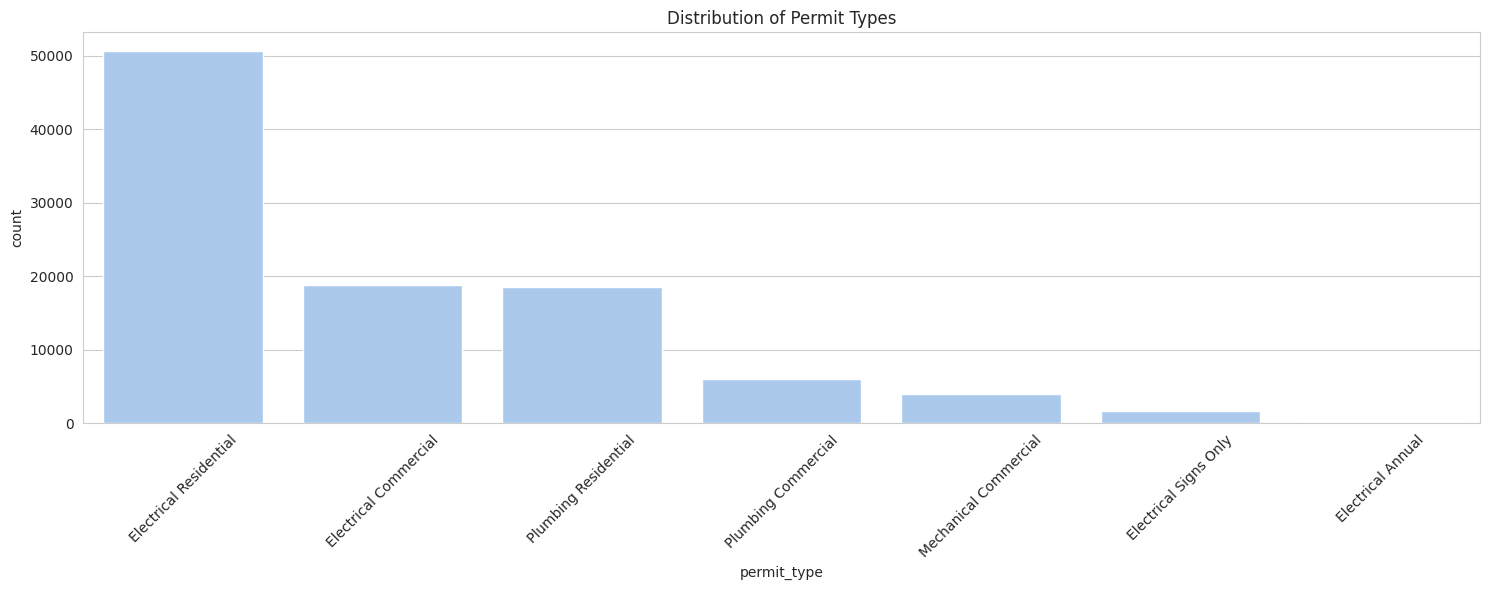

<Figure size 10x10 with 0 Axes>

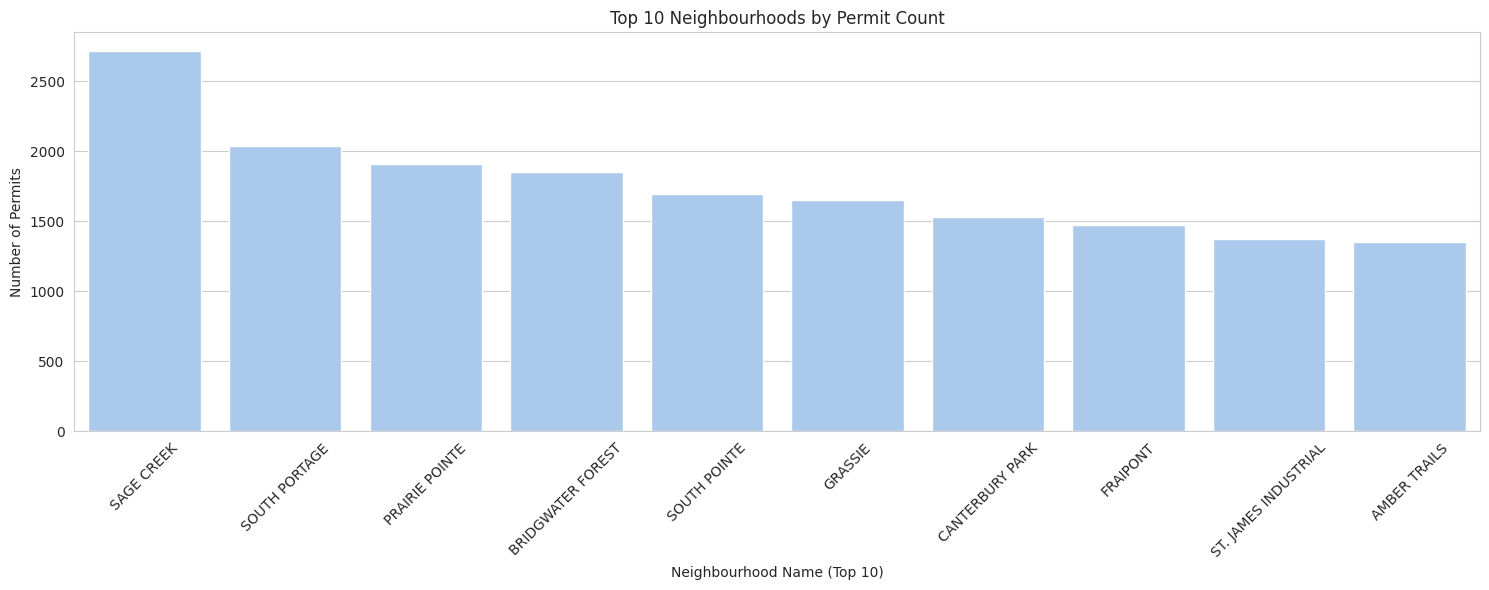

<Figure size 10x10 with 0 Axes>

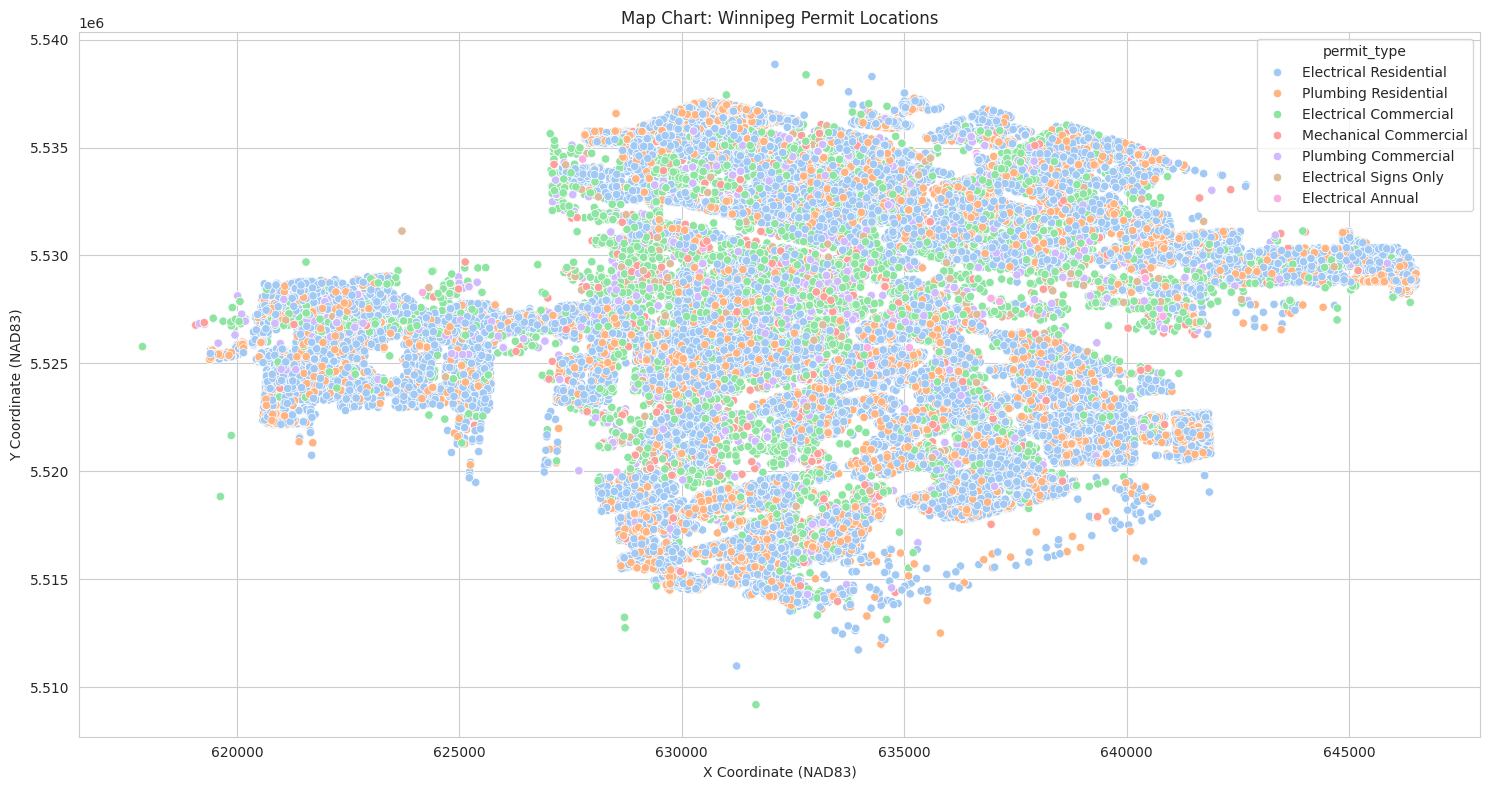

In [40]:
explore_data(df_processed)